# Busbar analysis

This example shows how to use PyAEDT to create a busbar design in
Q3D Extractor and run a simulation.

Keywords: **Q3D**, **EMC*, **busbar**.

## Perform imports and define constants

Perform required imports.

In [1]:
import os
import tempfile
import time

In [2]:
import ansys.aedt.core

Define constants.

In [3]:
AEDT_VERSION = "2024.2"
NUM_CORES = 4
NG_MODE = False

## Create temporary directory

Create a temporary directory where downloaded data or
dumped data can be stored.
If you'd like to retrieve the project data for subsequent use,
the temporary folder name is given by ``temp_folder.name``.

In [4]:
temp_folder = tempfile.TemporaryDirectory(suffix=".ansys")

## Launch AEDT and Q3D Extractor

Launch AEDT 2024 R2 in graphical mode and launch Q3D Extractor. This example uses SI units.

In [5]:
q3d = ansys.aedt.core.Q3d(
    project=os.path.join(temp_folder.name, "busbar.aedt"),
    version=AEDT_VERSION,
    non_graphical=NG_MODE,
    new_desktop=True,
)

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: PyAEDT version 0.12.dev0.


PyAEDT INFO: Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_54ef4328-a049-490b-bb6b-c74f15df5f45.log is enabled.


PyAEDT INFO: Log on AEDT is enabled.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: Launching PyAEDT with gRPC plugin.


PyAEDT INFO: New AEDT session is starting on gRPC port 58261


PyAEDT INFO: AEDT installation Path C:\Program Files\AnsysEM\v242\Win64


PyAEDT INFO: Ansoft.ElectronicsDesktop.2024.2 version started with process ID 6688.


PyAEDT INFO: Project busbar has been created.


PyAEDT INFO: No design is present. Inserting a new design.


PyAEDT INFO: Added design 'Q3D Extractor_UHP' of type Q3D Extractor.


PyAEDT INFO: Aedt Objects correctly read


## Create and set up the Q3D model

Create polylines for three busbars and a box for the substrate.

PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 1sec


PyAEDT INFO: Materials class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Parsing C:/Users/ansys/AppData/Local/Temp/tmpypvwdked.ansys/busbar.aedt.


PyAEDT INFO: File C:/Users/ansys/AppData/Local/Temp/tmpypvwdked.ansys/busbar.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.0


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


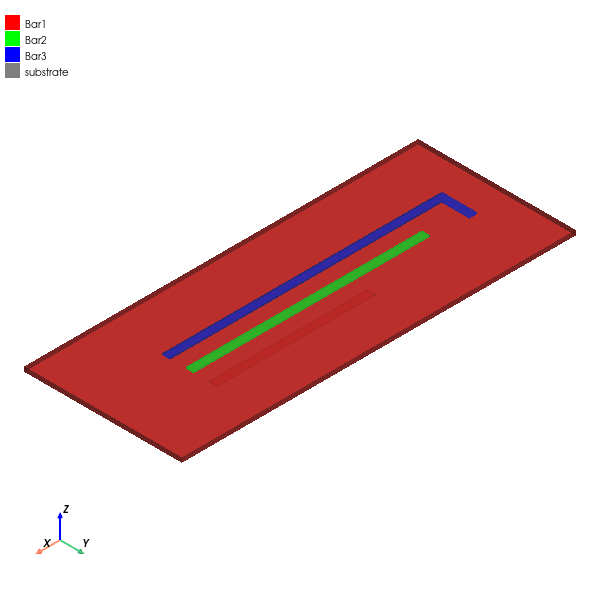

In [6]:
b1 = q3d.modeler.create_polyline(
    points=[[0, 0, 0], [-100, 0, 0]],
    name="Bar1",
    material="copper",
    xsection_type="Rectangle",
    xsection_width="5mm",
    xsection_height="1mm",
)
q3d.modeler["Bar1"].color = (255, 0, 0)

q3d.modeler.create_polyline(
    points=[[0, -15, 0], [-150, -15, 0]],
    name="Bar2",
    material="aluminum",
    xsection_type="Rectangle",
    xsection_width="5mm",
    xsection_height="1mm",
)
q3d.modeler["Bar2"].color = (0, 255, 0)

q3d.modeler.create_polyline(
    points=[[0, -30, 0], [-175, -30, 0], [-175, -10, 0]],
    name="Bar3",
    material="copper",
    xsection_type="Rectangle",
    xsection_width="5mm",
    xsection_height="1mm",
)
q3d.modeler["Bar3"].color = (0, 0, 255)

q3d.modeler.create_box(
    origin=[50, 30, -0.5],
    sizes=[-250, -100, -3],
    name="substrate",
    material="FR4_epoxy",
)
q3d.modeler["substrate"].color = (128, 128, 128)
q3d.modeler["substrate"].transparency = 0.8

q3d.plot(
    show=False,
    output_file=os.path.join(temp_folder.name, "Q3D.jpg"),
    plot_air_objects=False,
)

Identify nets and assign sources and sinks to all nets.
There is a source and sink for each busbar.

In [7]:
q3d.auto_identify_nets()

q3d.source(assignment="Bar1", direction=q3d.AxisDir.XPos, name="Source1")
q3d.sink(assignment="Bar1", direction=q3d.AxisDir.XNeg, name="Sink1")

q3d.source(assignment="Bar2", direction=q3d.AxisDir.XPos, name="Source2")
q3d.sink(assignment="Bar2", direction=q3d.AxisDir.XNeg, name="Sink2")
q3d.source(assignment="Bar3", direction=q3d.AxisDir.XPos, name="Source3")
bar3_sink = q3d.sink(assignment="Bar3", direction=q3d.AxisDir.YPos, name="Sink3")

PyAEDT INFO: 3 Nets have been identified: Bar1, Bar2, Bar3


Print information about nets and terminal assignments.

In [8]:
print(q3d.nets)
print(q3d.net_sinks("Bar1"))
print(q3d.net_sinks("Bar2"))
print(q3d.net_sinks("Bar3"))
print(q3d.net_sources("Bar1"))
print(q3d.net_sources("Bar2"))
print(q3d.net_sources("Bar3"))

['Bar1', 'Bar2', 'Bar3']
['Sink1']
['Sink2']
['Sink3']
['Source1']
['Source2']
['Source3']


Create the solution setup and define the frequency range for the solution.

In [9]:
setup1 = q3d.create_setup(props={"AdaptiveFreq": "100MHz"})
sweep = setup1.add_sweep()
sweep.props["RangeStart"] = "1MHz"
sweep.props["RangeEnd"] = "100MHz"
sweep.props["RangeStep"] = "5MHz"
sweep.update()

True

### Set up for postprocessing

Specify the traces to display after solving the model.

In [10]:
data_plot_self = q3d.matrices[0].get_sources_for_plot(
    get_self_terms=True, get_mutual_terms=False
)
data_plot_mutual = q3d.get_traces_for_plot(
    get_self_terms=False, get_mutual_terms=True, category="C"
)

Define a plot and a data table in AEDT for visualizing results.

In [11]:
q3d.post.create_report(expressions=data_plot_self)
q3d.post.create_report(
    expressions=data_plot_mutual, context="Original", plot_type="Data Table"
)

## Analyze

Solve the setup.

In [12]:
q3d.analyze(cores=NUM_CORES)
q3d.save_project()

PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/Q3D Extractor correctly changed.


PyAEDT INFO: Solving all design setups.


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/Q3D Extractor correctly changed.


PyAEDT INFO: Design setup None solved correctly in 0.0h 1.0m 1.0s


PyAEDT INFO: Project busbar Saved correctly


True

Retrieve solution data for processing in Python.

PyAEDT INFO: Solution Data Correctly Loaded.


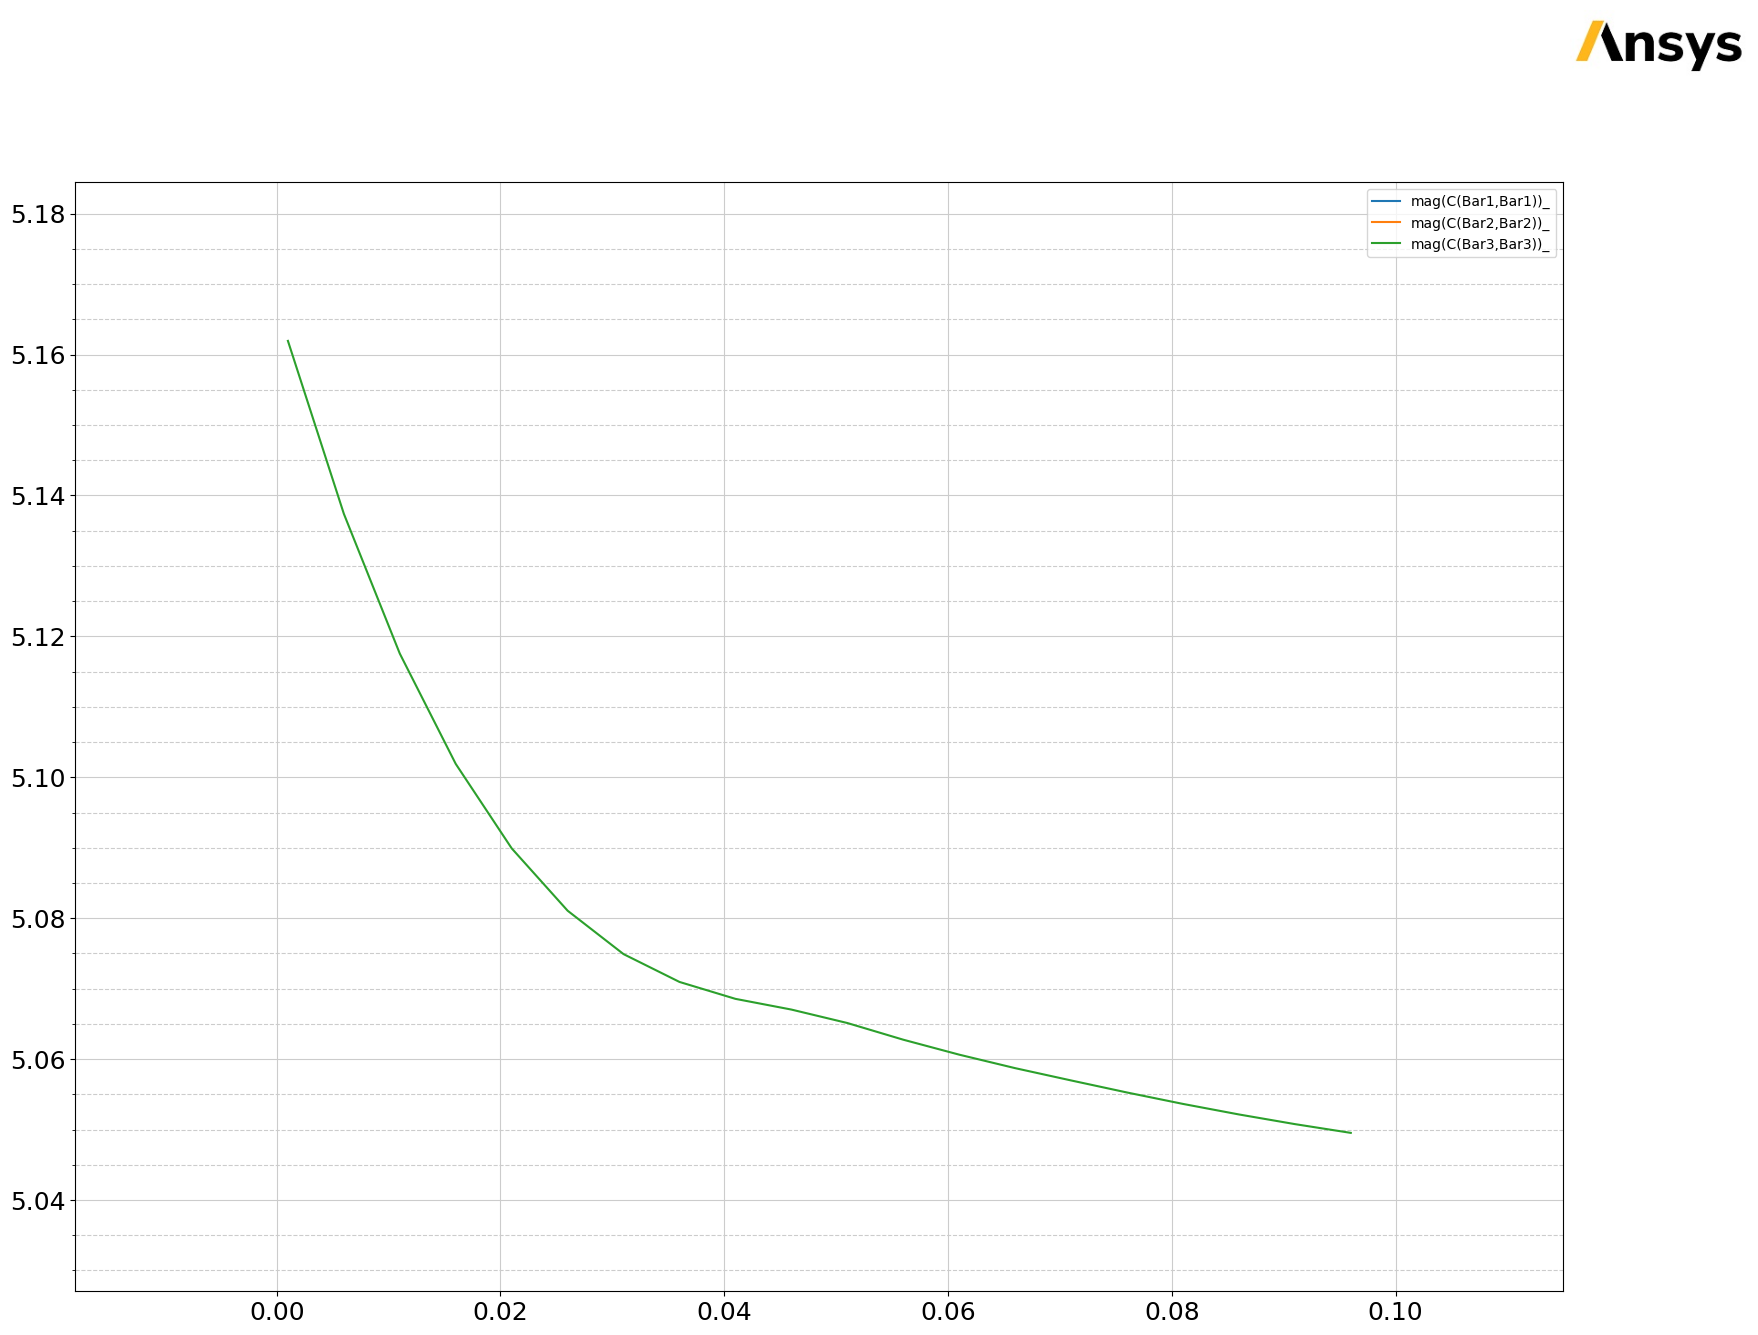

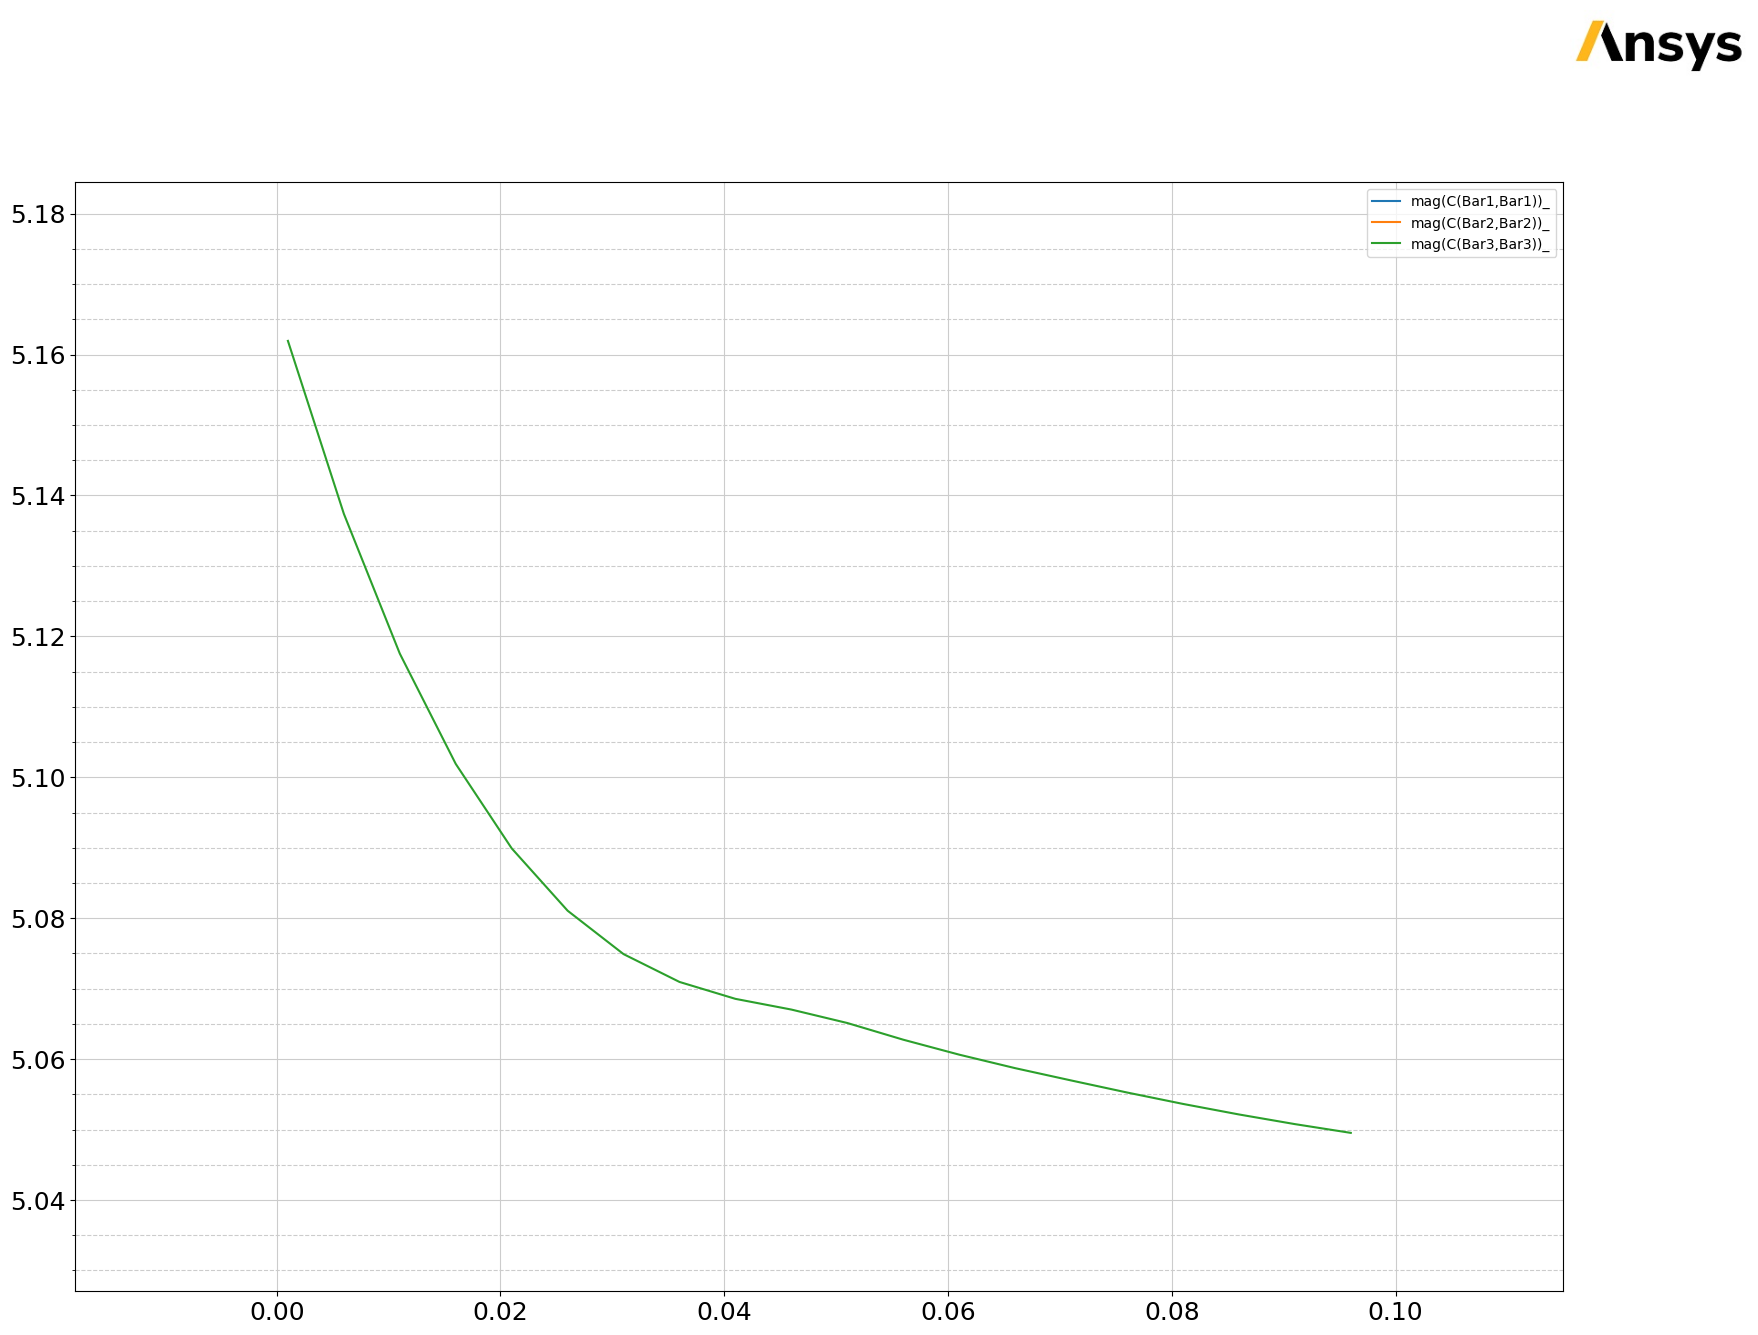

In [13]:
data = q3d.post.get_solution_data(expressions=data_plot_self, context="Original")
data.data_magnitude()
data.plot()

## Release AEDT

In [14]:
q3d.save_project()
q3d.release_desktop()
# Wait 3 seconds to allow AEDT to shut down before cleaning the temporary directory.
time.sleep(3)

PyAEDT INFO: Project busbar Saved correctly


PyAEDT INFO: Desktop has been released and closed.


## Clean up

All project files are saved in the folder ``temp_folder.name``.
If you've run this example as a Jupyter notebook, you
can retrieve those project files. The following cell
removes all temporary files, including the project folder.

In [15]:
temp_folder.cleanup()